In [1]:
from gernerate_data import load_clas_seg_data
import tensorflow as tf
from sklearn.metrics import classification_report, auc, roc_curve
from keras.utils.np_utils import *
from keras.callbacks import LearningRateScheduler
from models.MTL_IBA import MTL_IBA, MTL_IBA_h3
from models.MLT_net import MTL_classic
# from models.shareLayer import create_pair_model
from sklearn.preprocessing import LabelBinarizer, label_binarize
from utils.losses import dice_coef_loss, dice_coef, dice_p_bce, dice_p_focal, tversky_loss, focal_loss, focal_tversky, \
    p_r_f1_iou, generalized_dice_coeff, generalized_dice_loss
from keras.losses import categorical_crossentropy, mean_squared_error, binary_crossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras.backend as K
import utils_paths
import numpy as np
import pickle
import os

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
INIT_LR = 2e-4
EPOCHS =200
batch_size = 8
depth = 3
img_size = 224
Name = "MTL_classic"
GPU = True
target = (img_size, img_size)

if GPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"


    
print("------------------------------------------------ Preparing model ------------------------------------------------")
# model = MTL_3(img_size, img_size, depth, nClasses=2)
# model = MTL_IBA(img_size, img_size, depth, nClasses=2)
# model = MTL_IBA_h3(img_size, img_size, depth, nClasses=2)
model = MTL_classic(img_size, img_size, depth, nClasses=2)
model.summary()

------------------------------------------------ Preparing model ------------------------------------------------
Instructions for updating:
Colocations handled automatically by placer.


2022-03-29 13:43:25.569338: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-03-29 13:43:25.605194: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200095000 Hz
2022-03-29 13:43:25.609697: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x6f9e060 executing computations on platform Host. Devices:
2022-03-29 13:43:25.609817: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-03-29 13:43:26.537646: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x704a0a0 executing computations on platform CUDA. Devices:
2022-03-29 13:43:26.537737: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-03-29 13:43:26.538845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: Tes

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]          

In [3]:
# trainX_dir = 'dataset/LE/test/images/'
trainX_dir = 'dataset/Dataset_BUSI_AN/train/images/'
valX_dir = trainX_dir.replace('train', 'val')
testX_dir = trainX_dir.replace('train', 'test')


train_x,  train_c_y, train_s_y = load_clas_seg_data(trainX_dir, target)
val_x, val_c_y, val_s_y = load_clas_seg_data(valX_dir, target)
test_x, test_c_y, test_s_y = load_clas_seg_data(testX_dir, target)


lb = LabelBinarizer()
train_c_y = lb.fit_transform(train_c_y)
val_c_y = lb.fit_transform(val_c_y)
test_c_y = lb.fit_transform(test_c_y)
train_c_y = to_categorical(train_c_y, 2)
val_c_y = to_categorical(val_c_y, 2)
test_c_y = to_categorical(test_c_y, 2)

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (337)_1a541313-68f8-4236-86da-3a7f4c227d83.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (337)_1a541313-68f8-4236-86da-3a7f4c227d83.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (396).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (396).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (435).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (435).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (91)_755a6075-3551-47bc-9a8f-e6919826a078.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (91)_755a6075-3551-47bc-9a8f-e6919826a078.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (214).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (214).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (415).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (415).png
dataset/Dataset_BUSI_AN/train/images/bengin_images

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (366).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (366).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (258).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (258).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (306).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (306).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (195)_14ffd644-6700-46fd-8ecd-696554c2474b.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (195)_14ffd644-6700-46fd-8ecd-696554c2474b.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (326).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (326).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (368).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (368).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (403).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benig

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (2)_a52c747d-e287-4962-828f-eafb4652d217.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (2)_a52c747d-e287-4962-828f-eafb4652d217.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (43)_97e6519b-05e9-441f-b76c-17c0fcaeabe7.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (43)_97e6519b-05e9-441f-b76c-17c0fcaeabe7.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (159).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (159).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (272)_cf40ffd7-d67c-4567-91fc-f3093c0f8ec1.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (272)_cf40ffd7-d67c-4567-91fc-f3093c0f8ec1.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (83)_0b0a9fab-8531-4867-a354-eb2b37e75d22.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (83)_0b0a9fab-8531-4867-a354-eb2b37e75d22.png
dataset/Dataset_BUSI_AN/train/images/bengi

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (345).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (345).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (376)_6e0b291d-45e3-4ff8-aa59-65d83b825bdc.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (376)_6e0b291d-45e3-4ff8-aa59-65d83b825bdc.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (240).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (240).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (19).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (19).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (355)_da484afe-bda8-461d-8ade-2f375f3209e0.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (355)_da484afe-bda8-461d-8ade-2f375f3209e0.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (352).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (352).png
dataset/Dataset_BUSI_AN/train/images/bengin_images

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (394).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (394).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (395).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (395).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (314).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (314).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (331).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (331).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (395)_abb803a4-f8b9-4f07-91a2-ee4cac6e5f4a.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (395)_abb803a4-f8b9-4f07-91a2-ee4cac6e5f4a.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (431).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (431).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (180).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benig

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (13).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (13).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (289)_de6d549d-79e1-405f-b5a6-87b074a51763.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (289)_de6d549d-79e1-405f-b5a6-87b074a51763.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (143).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (143).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (233).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (233).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (376).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (376).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (351).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (351).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (130).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign 

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (196).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (196).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (340).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (340).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (400).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (400).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (165).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (165).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (256)_9926da47-f93a-4f03-ad83-4c63fa26ae1b.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (256)_9926da47-f93a-4f03-ad83-4c63fa26ae1b.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (71)_e9a11630-5b4c-4c74-be8e-2bac194a0389.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (71)_e9a11630-5b4c-4c74-be8e-2bac194a0389.png
dataset/Dataset_BUSI_AN/train/images/bengin_images

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (29).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (29).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (70).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (70).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (129).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (129).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (360)_c1263e47-b716-4020-98b3-278a0ea089c4.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (360)_c1263e47-b716-4020-98b3-278a0ea089c4.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (199)_a375d418-def1-452c-9f1e-a0716394c0bf.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (199)_a375d418-def1-452c-9f1e-a0716394c0bf.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (44)_a050c753-3ebe-4fd8-8fe9-f70511812429.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (44)_a050c753-3ebe-4fd8-8f

dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (348).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (348).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (205).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (205).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (279).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (279).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (428)_3ae1ea61-ae2b-4a94-8097-c8c9db50ff20.png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (428)_3ae1ea61-ae2b-4a94-8097-c8c9db50ff20.png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (275).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (275).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (216).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign (216).png
dataset/Dataset_BUSI_AN/train/images/bengin_images/benign (41).png
dataset/Dataset_BUSI_AN/train/masks/bengin_masks/benign

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (58)_39392951-437f-4c69-9d3c-ab652e3356b2.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (58)_39392951-437f-4c69-9d3c-ab652e3356b2.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (43)_d2a6d920-124a-419f-8382-7f88068ecf25.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (43)_d2a6d920-124a-419f-8382-7f88068ecf25.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (57).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (57).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (145)_1ebcef80-0158-43a0-bcd5-cbe33548f100.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (145)_1ebcef80-0158-43a0-bcd5-cbe33548f100.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (97)_e3bb9366-ba6b-4f05-822b-4a217b1c08f9.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (97)_e3bb9366-ba6b-4f05-822b

dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (56)_5a5f7ddb-8704-4d76-9d81-b1982b8519dd.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (180).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (180).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (164).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (164).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (9).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (9).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (23)_4a11763c-6edb-410d-95e3-d9c85985abda.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (23)_4a11763c-6edb-410d-95e3-d9c85985abda.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (24).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (24).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (108)_c7764959-2242-4687-820c-0c

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (150)_bbc76458-1dbd-46d0-9a7d-cc0acfdce043.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (150)_bbc76458-1dbd-46d0-9a7d-cc0acfdce043.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (77).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (77).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (29)_d195f9f5-9985-4455-be8f-ff9667ab7a64.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (29)_d195f9f5-9985-4455-be8f-ff9667ab7a64.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (47)_15293bb1-e8d8-4a9e-bba4-be37e51c03ab.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (47)_15293bb1-e8d8-4a9e-bba4-be37e51c03ab.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (147)_809a6153-4892-469a-8f8a-aa0e204b20c4.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (147)_809a6153-4892-469a-8f

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (135)_e83fc8e9-348f-4563-880a-ee176961e597.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (135)_e83fc8e9-348f-4563-880a-ee176961e597.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (210).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (210).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (133).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (133).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (179)_13929563-86ef-4610-a6de-41b3a60ab41f.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (179)_13929563-86ef-4610-a6de-41b3a60ab41f.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (69)_373c7fd6-47f4-414c-a4f3-1110a7a1379b.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (69)_373c7fd6-47f4-414c-a4f3-1110a7a1379b.png
dataset/Dataset_BUSI_AN/train/images/malignant_ima

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (182)_3c18e1f2-eaa4-4dfc-9740-8a9fea3d2964.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (182)_3c18e1f2-eaa4-4dfc-9740-8a9fea3d2964.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (8).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (8).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (58)_24325e04-079f-40b1-a688-a659122acb0e.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (58)_24325e04-079f-40b1-a688-a659122acb0e.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (209).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (209).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (109).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (109).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (61)_bec32024-cea4-4bd7-9370-745ed34fe953.png
dataset/Dataset_BU

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (99).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (99).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (167)_e9d9215b-d701-4da8-bbcc-68e8dcc32958.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (167)_e9d9215b-d701-4da8-bbcc-68e8dcc32958.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (130)_fc09bae4-341a-44c3-84f2-eb3d1dd59921.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (130)_fc09bae4-341a-44c3-84f2-eb3d1dd59921.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (78)_8b547405-2f6c-4c89-8dcc-cbeddc7c81e5.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (78)_8b547405-2f6c-4c89-8dcc-cbeddc7c81e5.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (51).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (51).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (143).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (143).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (209)_1b92e5b7-1178-4e40-9e40-8ec8ce97f258.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (209)_1b92e5b7-1178-4e40-9e40-8ec8ce97f258.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (97)_58985c29-9c35-4ecf-b6f4-40c471e2b1ca.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (97)_58985c29-9c35-4ecf-b6f4-40c471e2b1ca.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (166).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (166).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (15).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (15).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (71).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/m

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (153).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (153).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (185).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (185).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (168)_f0e0c789-6831-4c8c-b327-ba3815f7355b.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (168)_f0e0c789-6831-4c8c-b327-ba3815f7355b.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (127).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (127).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (166)_37ac0569-9a85-4651-b037-11cdde769803.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (166)_37ac0569-9a85-4651-b037-11cdde769803.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (173).png
dataset/Dataset_BUSI_AN/train/masks/malignant_ma

dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (188).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (188).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (31).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (31).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (156)_0f0c58af-a1ee-411b-8ab2-6ad13341a9ba.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (156)_0f0c58af-a1ee-411b-8ab2-6ad13341a9ba.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (122)_31324f0b-c754-4761-bc00-2ea9f3def749.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (122)_31324f0b-c754-4761-bc00-2ea9f3def749.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (62).png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (62).png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (151)_a53a9a99-d7c2-4b8a-b034-c1d8f3872954.png
dataset/Dataset

dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (22)_958ca975-48ed-4e6c-9cea-8ca150ff29fb.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (73)_601dcd4a-5568-4ec9-ae7c-d0e6e76cfa44.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (73)_601dcd4a-5568-4ec9-ae7c-d0e6e76cfa44.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (127)_3cfdc87c-b2e5-4b44-8879-cfd17f237e37.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (127)_3cfdc87c-b2e5-4b44-8879-cfd17f237e37.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (71)_68f739c4-3684-49f8-8195-2760d5442781.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (71)_68f739c4-3684-49f8-8195-2760d5442781.png
dataset/Dataset_BUSI_AN/train/images/malignant_images/malignant (181)_447e9378-af8f-444d-a58e-a36f26f5202a.png
dataset/Dataset_BUSI_AN/train/masks/malignant_masks/malignant (181)_447e9378-af8f-444d-a58e-a36f26f5202a.png
dataset/Dataset_

dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (236).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (236).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (252).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (252).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (343).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (343).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (18).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (18).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (114).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (114).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (215).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (215).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (133).png
dataset/Dataset_BUSI_AN/val/masks/bengin_masks/benign (133).png
dataset/Dataset_BUSI_AN/val/images/bengin_images/benign (312).png
dataset/Dataset_BUSI_AN/va

dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (57).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (57).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (48).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (48).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (316).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (316).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (372).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (372).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (297).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (297).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (391).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (391).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (321).png
dataset/Dataset_BUSI_AN/test/masks/bengin_masks/benign (321).png
dataset/Dataset_BUSI_AN/test/images/bengin_images/benign (104).png
dataset/Datas

In [4]:
# from models.shareLayer import create_pair_model
# from models.MLT_net import MTL_classic, MTL_3

# model = MTL_classic(img_size, img_size, depth, nClasses=2)
# model = MTL_3(img_size, img_size, depth, nClasses=2)
# model = create_pair_model(img_size, img_size, depth, nClasses=2)
# model.summary()


# define callbacks
csv_logger = CSVLogger(Name+'.log')

reduce_lr = ReduceLROnPlateau(monitor='classification_output_loss', factor=0.2, patience=20, min_lr=1e-8, mode='auto', verbose=1)

checkpoint_period1 = ModelCheckpoint(Name + '-{epoch:03d}-{classification_output_acc:.4f}.h5',
                                     monitor='classification_output_acc', mode='auto', save_best_only='True')



# define loss and compile the model

opt = Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.01)

def binary_crossentropy(y_true, y_pred):
    e=1.0
    return K.mean(-(y_true*K.log(y_pred+K.epsilon())+
                    e*(1-y_true)*K.log(1-y_pred+K.epsilon())),
                  axis=-1)

def tversky(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


from keras.losses import categorical_crossentropy

# model.compile(loss={'segmentation_output': categorical_crossentropy, 'seg-out': tversky_loss, "classification_output": binary_crossentropy},
#               loss_weights={'segmentation_output': 0.25,'seg-out': 0.5, "classification_output": 0.5},
#               optimizer=opt, 
#               metrics={'segmentation_output':'accuracy', 'seg-out':dice_coef, 'classification_output':'accuracy'})

# model.compile(loss={'segmentation_output': categorical_crossentropy, 'seg-out': tversky_loss, "classification_output": binary_crossentropy},
#               loss_weights={'segmentation_output': 0.25,'seg-out': 0.5, "classification_output": 0.5},
#               optimizer=opt, 
#               metrics={'segmentation_output':'accuracy', 'seg-out':dice_coef, 'classification_output':'accuracy'})

# # model.compile(loss={'segmentation_output': focal_tversky, "classification_output": binary_crossentropy},
model.compile(loss={'segmentation_output': tversky_loss, "classification_output": binary_crossentropy},
              loss_weights={'segmentation_output': 0.5, "classification_output": 0.5},
              optimizer=opt, 
              metrics={'segmentation_output':['accuracy', dice_coef], 'classification_output':'accuracy'})

# model.compile(loss={'seg_out': 'categorical_crossentropy', 'cls_out': binary_crossentropy},
#               optimizer=Adam(lr=1e-4), metrics={'seg_out':dice_coef, 'cls_out':'accuracy'},
#               loss_weights={'seg_out':0.5, 'cls_out':0.5})


In [5]:

# print("================================================ begin training ================================================")

# hist = model.fit(train_x,
#                  [train_c_y, train_s_y, train_s_y],
#                  batch_size=batch_size,
#                  epochs=200,
#                  validation_data=(val_x, [val_c_y, val_s_y, val_s_y]),
#                  verbose=1,
#                  callbacks=[reduce_lr, csv_logger],
#                  shuffle=True)

# print("================================================ Saving model ================================================")
# model_filename = Name + ".h5"
# model.save_weights(model_filename)
# print('model saved to:', model_filename)


print("================================================ begin training ================================================")

hist = model.fit(train_x,
                 [train_c_y, train_s_y],
                 batch_size=batch_size,
                 epochs=200,
                 validation_data=(val_x, [val_c_y, val_s_y]),
                 verbose=1,
                 callbacks=[reduce_lr, csv_logger],
                 shuffle=True)

print("================================================ Saving model ================================================")
model_filename = Name + ".h5"
model.save_weights(model_filename)
print('model saved to:', model_filename)


# print("================================================ begin training ================================================")

# hist = model.fit([train_x,train_x],
#                  [train_c_y, train_s_y],
#                  batch_size=batch_size,
#                  epochs=200,
#                  validation_data=([val_x,val_x], [val_c_y, val_s_y]),
#                  verbose=1,
#                  callbacks=[reduce_lr, csv_logger],
#                  shuffle=True)

# print("================================================ Saving model ================================================")
# model_filename = Name + ".h5"
# model.save_weights(model_filename)
# print('model saved to:', model_filename)


================================================ begin training ================================================
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1000 samples, validate on 64 samples
Epoch 1/200


2022-03-29 13:43:58.673299: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


1000/1000 [==============================] - 66s 66ms/step - loss: 0.4521 - classification_output_loss: 0.6959 - segmentation_output_loss: 0.2083 - classification_output_acc: 0.5020 - segmentation_output_acc: 0.8788 - segmentation_output_dice_coef: 0.7917 - val_loss: 0.4238 - val_classification_output_loss: 0.6931 - val_segmentation_output_loss: 0.1545 - val_classification_output_acc: 0.6719 - val_segmentation_output_acc: 0.9146 - val_segmentation_output_dice_coef: 0.8455
Epoch 2/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4206 - classification_output_loss: 0.6953 - segmentation_output_loss: 0.1458 - classification_output_acc: 0.5090 - segmentation_output_acc: 0.8829 - segmentation_output_dice_coef: 0.8542 - val_loss: 0.4022 - val_classification_output_loss: 0.6931 - val_segmentation_output_loss: 0.1113 - val_classification_output_acc: 0.6719 - val_segmentation_output_acc: 0.9146 - val_segmentation_output_dice_coef: 0.8887
Epoch 3/200
1000/1000 [===========

Epoch 18/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2885 - classification_output_loss: 0.5182 - segmentation_output_loss: 0.0589 - classification_output_acc: 0.8420 - segmentation_output_acc: 0.9569 - segmentation_output_dice_coef: 0.9411 - val_loss: 0.2636 - val_classification_output_loss: 0.4628 - val_segmentation_output_loss: 0.0644 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9508 - val_segmentation_output_dice_coef: 0.9356
Epoch 19/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2829 - classification_output_loss: 0.5084 - segmentation_output_loss: 0.0574 - classification_output_acc: 0.8610 - segmentation_output_acc: 0.9579 - segmentation_output_dice_coef: 0.9426 - val_loss: 0.2580 - val_classification_output_loss: 0.4515 - val_segmentation_output_loss: 0.0645 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9500 - val_segmentation_output_dice_coef: 0.9355
Epoch 20/200
1000/10

Epoch 35/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2165 - classification_output_loss: 0.3875 - segmentation_output_loss: 0.0456 - classification_output_acc: 0.9810 - segmentation_output_acc: 0.9660 - segmentation_output_dice_coef: 0.9544 - val_loss: 0.2250 - val_classification_output_loss: 0.3862 - val_segmentation_output_loss: 0.0638 - val_classification_output_acc: 0.9375 - val_segmentation_output_acc: 0.9471 - val_segmentation_output_dice_coef: 0.9362
Epoch 36/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2125 - classification_output_loss: 0.3795 - segmentation_output_loss: 0.0455 - classification_output_acc: 0.9860 - segmentation_output_acc: 0.9661 - segmentation_output_dice_coef: 0.9545 - val_loss: 0.2076 - val_classification_output_loss: 0.3552 - val_segmentation_output_loss: 0.0600 - val_classification_output_acc: 1.0000 - val_segmentation_output_acc: 0.9510 - val_segmentation_output_dice_coef: 0.9400
Epoch 37/200
1000/10

Epoch 52/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1980 - classification_output_loss: 0.3586 - segmentation_output_loss: 0.0374 - classification_output_acc: 0.9930 - segmentation_output_acc: 0.9723 - segmentation_output_dice_coef: 0.9626 - val_loss: 0.2245 - val_classification_output_loss: 0.3902 - val_segmentation_output_loss: 0.0588 - val_classification_output_acc: 0.9531 - val_segmentation_output_acc: 0.9504 - val_segmentation_output_dice_coef: 0.9412
Epoch 53/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1988 - classification_output_loss: 0.3603 - segmentation_output_loss: 0.0374 - classification_output_acc: 0.9960 - segmentation_output_acc: 0.9724 - segmentation_output_dice_coef: 0.9626 - val_loss: 0.2132 - val_classification_output_loss: 0.3667 - val_segmentation_output_loss: 0.0596 - val_classification_output_acc: 1.0000 - val_segmentation_output_acc: 0.9495 - val_segmentation_output_dice_coef: 0.9404
Epoch 54/200
1000/10

Epoch 69/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1951 - classification_output_loss: 0.3575 - segmentation_output_loss: 0.0327 - classification_output_acc: 0.9920 - segmentation_output_acc: 0.9758 - segmentation_output_dice_coef: 0.9673 - val_loss: 0.2087 - val_classification_output_loss: 0.3602 - val_segmentation_output_loss: 0.0571 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9511 - val_segmentation_output_dice_coef: 0.9429
Epoch 70/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1936 - classification_output_loss: 0.3549 - segmentation_output_loss: 0.0323 - classification_output_acc: 0.9960 - segmentation_output_acc: 0.9762 - segmentation_output_dice_coef: 0.9677 - val_loss: 0.2069 - val_classification_output_loss: 0.3567 - val_segmentation_output_loss: 0.0571 - val_classification_output_acc: 1.0000 - val_segmentation_output_acc: 0.9508 - val_segmentation_output_dice_coef: 0.9429
Epoch 71/200
1000/10

Epoch 86/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1908 - classification_output_loss: 0.3529 - segmentation_output_loss: 0.0287 - classification_output_acc: 0.9970 - segmentation_output_acc: 0.9790 - segmentation_output_dice_coef: 0.9713 - val_loss: 0.2048 - val_classification_output_loss: 0.3512 - val_segmentation_output_loss: 0.0585 - val_classification_output_acc: 1.0000 - val_segmentation_output_acc: 0.9486 - val_segmentation_output_dice_coef: 0.9415
Epoch 87/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1902 - classification_output_loss: 0.3518 - segmentation_output_loss: 0.0286 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9791 - segmentation_output_dice_coef: 0.9714 - val_loss: 0.2111 - val_classification_output_loss: 0.3652 - val_segmentation_output_loss: 0.0569 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9504 - val_segmentation_output_dice_coef: 0.9431
Epoch 88/200
1000/10

Epoch 103/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1906 - classification_output_loss: 0.3557 - segmentation_output_loss: 0.0255 - classification_output_acc: 0.9960 - segmentation_output_acc: 0.9816 - segmentation_output_dice_coef: 0.9745 - val_loss: 0.2082 - val_classification_output_loss: 0.3584 - val_segmentation_output_loss: 0.0580 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9487 - val_segmentation_output_dice_coef: 0.9420
Epoch 104/200
1000/1000 [==============================] - 37s 37ms/step - loss: 0.1887 - classification_output_loss: 0.3523 - segmentation_output_loss: 0.0251 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9819 - segmentation_output_dice_coef: 0.9749 - val_loss: 0.2134 - val_classification_output_loss: 0.3728 - val_segmentation_output_loss: 0.0541 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9526 - val_segmentation_output_dice_coef: 0.9459
Epoch 105/200
1000

Epoch 120/200
1000/1000 [==============================] - 37s 37ms/step - loss: 0.1863 - classification_output_loss: 0.3496 - segmentation_output_loss: 0.0230 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9835 - segmentation_output_dice_coef: 0.9770 - val_loss: 0.2145 - val_classification_output_loss: 0.3717 - val_segmentation_output_loss: 0.0573 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9489 - val_segmentation_output_dice_coef: 0.9427
Epoch 121/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1882 - classification_output_loss: 0.3535 - segmentation_output_loss: 0.0228 - classification_output_acc: 0.9970 - segmentation_output_acc: 0.9836 - segmentation_output_dice_coef: 0.9772 - val_loss: 0.2138 - val_classification_output_loss: 0.3724 - val_segmentation_output_loss: 0.0552 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9511 - val_segmentation_output_dice_coef: 0.9448
Epoch 122/200
1000

Epoch 137/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1858 - classification_output_loss: 0.3505 - segmentation_output_loss: 0.0210 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9849 - segmentation_output_dice_coef: 0.9790 - val_loss: 0.2142 - val_classification_output_loss: 0.3708 - val_segmentation_output_loss: 0.0575 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9482 - val_segmentation_output_dice_coef: 0.9425
Epoch 138/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1872 - classification_output_loss: 0.3527 - segmentation_output_loss: 0.0218 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9843 - segmentation_output_dice_coef: 0.9782 - val_loss: 0.2132 - val_classification_output_loss: 0.3697 - val_segmentation_output_loss: 0.0567 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9489 - val_segmentation_output_dice_coef: 0.9433
Epoch 139/200
1000

1000/1000 [==============================] - 36s 36ms/step - loss: 0.1863 - classification_output_loss: 0.3524 - segmentation_output_loss: 0.0201 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9856 - segmentation_output_dice_coef: 0.9799 - val_loss: 0.2152 - val_classification_output_loss: 0.3741 - val_segmentation_output_loss: 0.0562 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9494 - val_segmentation_output_dice_coef: 0.9438
Epoch 154/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1849 - classification_output_loss: 0.3495 - segmentation_output_loss: 0.0202 - classification_output_acc: 0.9990 - segmentation_output_acc: 0.9856 - segmentation_output_dice_coef: 0.9798 - val_loss: 0.2152 - val_classification_output_loss: 0.3742 - val_segmentation_output_loss: 0.0563 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9493 - val_segmentation_output_dice_coef: 0.9437
Epoch 155/200
1000/1000 [=======

Epoch 170/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1848 - classification_output_loss: 0.3497 - segmentation_output_loss: 0.0198 - classification_output_acc: 0.9990 - segmentation_output_acc: 0.9859 - segmentation_output_dice_coef: 0.9802 - val_loss: 0.2160 - val_classification_output_loss: 0.3751 - val_segmentation_output_loss: 0.0569 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9487 - val_segmentation_output_dice_coef: 0.9431
Epoch 171/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1860 - classification_output_loss: 0.3521 - segmentation_output_loss: 0.0199 - classification_output_acc: 0.9970 - segmentation_output_acc: 0.9858 - segmentation_output_dice_coef: 0.9801 - val_loss: 0.2161 - val_classification_output_loss: 0.3754 - val_segmentation_output_loss: 0.0567 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9488 - val_segmentation_output_dice_coef: 0.9433
Epoch 172/200
1000

1000/1000 [==============================] - 36s 36ms/step - loss: 0.1854 - classification_output_loss: 0.3510 - segmentation_output_loss: 0.0198 - classification_output_acc: 0.9980 - segmentation_output_acc: 0.9860 - segmentation_output_dice_coef: 0.9802 - val_loss: 0.2154 - val_classification_output_loss: 0.3741 - val_segmentation_output_loss: 0.0568 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9488 - val_segmentation_output_dice_coef: 0.9432
Epoch 187/200
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1847 - classification_output_loss: 0.3495 - segmentation_output_loss: 0.0198 - classification_output_acc: 1.0000 - segmentation_output_acc: 0.9859 - segmentation_output_dice_coef: 0.9802 - val_loss: 0.2155 - val_classification_output_loss: 0.3742 - val_segmentation_output_loss: 0.0567 - val_classification_output_acc: 0.9844 - val_segmentation_output_acc: 0.9488 - val_segmentation_output_dice_coef: 0.9433
Epoch 188/200
1000/1000 [=======

KeyError: 'seg-out_dice_coef'

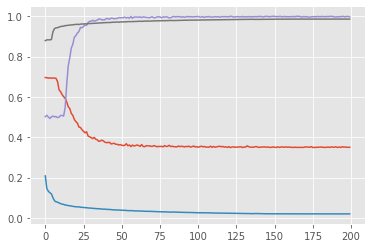

In [6]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["classification_output_loss"], label="train_c_loss")
plt.plot(N, hist.history["segmentation_output_loss"], label="train_s_loss")

plt.plot(N, hist.history["classification_output_acc"], label="train_c_acc")
plt.plot(N, hist.history["segmentation_output_acc"], label="train_s_acc")
plt.plot(N, hist.history["seg-out_dice_coef"], label="train_s_dice")

# plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.plot(N, hist.history["val_classification_output_loss"], label="val_c_loss")
plt.plot(N, hist.history["val_segmentation_output_loss"], label="val_s_loss")

plt.plot(N, hist.history["val_classification_output_acc"], label="val_c_acc")
plt.plot(N, hist.history["val_segmentation_output_acc"], label="val_s_acc")
plt.plot(N, hist.history["val_seg-out_dice_coef"], label="val_s_dice")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/DSC")
plt.legend()
plt.savefig(os.path.join('output/', Name+'.png'))


In [ ]:
print("------Start predicting------")



predictions_c, predictions_s, predictions_s2 = model.predict(test_x, batch_size=32)


print("------------------------------------------------ Classification testing ------------------------------------------------")

print(classification_report(test_c_y.argmax(axis=1), predictions_c.argmax(axis=1), target_names=lb.classes_, digits=6))

print("------------------------------------------------ Segmentation testing ------------------------------------------------")


# evaluate the model
# loss = model.evaluate(test_x, [test_c_y, test_s_y], verbose=0)
loss, cla_loss, seg_loss, seg_loss2, cla_acc, seg_acc, seg_dice_coef = model.evaluate(test_x, [test_c_y, test_s_y, test_s_y], verbose=0)
print('Test total loss:', loss)
print('Test classification loss:', cla_loss)
print('Test segmentation loss:', seg_loss)

print('Test classification accuracy:', cla_acc)
print('Test segmentation accuracy:', seg_acc)
print('Test segmentation dice_coef:', seg_dice_coef)

preds_c, preds_s, preds_s2 = model.predict(test_x, batch_size=8, verbose=1)
test_mask = test_s_y.flatten()
pred_mask = preds_s.flatten()
fpr, tpr, thresholds = roc_curve(test_mask, pred_mask, pos_label=1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Precision, Recall, accuracy, F1, IoU = p_r_f1_iou(test_s_y, preds_s)
# print('Precision:', Precision)
# print('Recall:', Recall)
# print('m_Iou:', IoU)
# print('F1_score:', F1)

